<a href="https://colab.research.google.com/github/caarolgomesds/QM9_Chemical_Analysis/blob/main/Deliverable_4_Feature_Selection_CM_MBTR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Deliverable 4: Feature Evaluation and Selection**

Name: Carolina Gomes

RA: 122028

This notebook evaluates and compares two molecular descriptors, the Coulomb Matrix (CM) and the Many-Body Tensor Representation (MBTR). We will use a subset of the QM9 dataset to train a machine learning model to predict the electronic bandgap. The analysis pipeline uses LASSO CV to rank features and identifies the smallest feature subset required to maintain 95% of the full model's accuracy.

**Methodology:**
1.  **Data Acquisition:** Download and extract the QM9 dataset (`.xyz` files).
2.  **Processing:** Load a random subset of 5000 molecules, extracting their properties and structures.
3.  **Descriptor Generation:** Generate the feature vectors for both CM and MBTR.
4.  **Analysis (for each descriptor):**
    * Train a baseline model (Lasso) and evaluate its initial performance (R2, MAE).
    * Features that maintains 90-95% of the performance.
    * Visualize the performance degradation vs. the number of features.
    * Visualize the feature space using PCA and t-SNE.

# **Part 1: Setup and Data Loading**

First, we install the necessary libraries and import all required modules.

In [ ]:
# Install required packages
!pip install ase dscribe scikit-learn sparse requests tqdm -q

print("\n--- Dependencies Installed ---")
!pip show dscribe | grep Version


--- Dependencies Installed ---
Version: 2.1.2
                           Version 2.0, January 2004
   Licensed under the Apache License, Version 2.0 (the "License");


In [ ]:
# --- 1. Imports (Unified) ---
import os
import time
import tarfile
import requests
import warnings
import sys
import importlib.metadata
from pathlib import Path
from typing import List, Dict, Any, Tuple, Optional

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm # Using tqdm.notebook
from ase import Atoms
from ase.io import read

# Dask and Scikit-learn
try:
    import dscribe
    from dscribe.descriptors import CoulombMatrix, MBTR
    from sklearn.linear_model import Lasso, LassoCV, RidgeCV
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.metrics import mean_absolute_error, r2_score
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE
    from sklearn.exceptions import ConvergenceWarning
except ImportError as e:
    print(f"IMPORT ERROR: {e}. Install the libraries and restart.")
    sys.exit()

# Specific to Jupyter/IPython
try:
    from IPython.display import display
except ImportError:
    display = print  # Fallback for print if not in IPython

# Warning Configuration
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
sns.set_context("talk")
sns.set_style("whitegrid")

# Version check
try:
    dscribe_version = importlib.metadata.version("dscribe")
    print(f"dscribe version installed: {dscribe_version}")
except Exception as e:
    print(f"Warning: Could not verify dscribe version: {e}")

print("--- 1. Libraries imported ---")

dscribe version installed: 2.1.2
--- 1. Libraries imported ---


# **Part 2: Data Acquisition and Extraction**

In [ ]:
# --- Download and Extraction ---

def download_file(url, save_path):
    """Downloads a file with a progress bar."""
    print(f"Downloading '{os.path.basename(save_path)}'...")
    try:
        with requests.get(url, stream=True) as r:
            r.raise_for_status()
            total_size = int(r.headers.get('content-length', 0))
            with open(save_path, 'wb') as f, tqdm(
                desc=os.path.basename(save_path), total=total_size, unit='iB',
                unit_scale=True, unit_divisor=1024,
            ) as bar:
                for chunk in r.iter_content(chunk_size=8192):
                    size = f.write(chunk)
                    bar.update(size)
        return True
    except requests.exceptions.RequestException as e:
        print(f"Error during download of {url}: {e}")
        return False

def unpack_archive(archive_path, extract_path):
    """Extracts a .tar.bz2 file."""
    print(f"Extracting '{os.path.basename(archive_path)}'...")
    try:
        with tarfile.open(archive_path, 'r:bz2') as tar:
            members = tar.getmembers()
            for member in tqdm(members, desc="Extracting files"):
                tar.extract(member, path=extract_path)
        print("Extraction complete.")
    except (tarfile.TarError, OSError) as e:
        print(f"Error extracting {archive_path}: {e}")

# URLs and Filenames
DATA_URL = "https://ndownloader.figshare.com/files/3195389"
ARCHIVE_NAME = "dsgdb9nsd.tar.bz2"
EXTRACT_DIR = "qm9_xyz_files"

def setup_data_directory(url, archive_name, extract_dir):
    """Manages data download and extraction."""
    if not os.path.exists(extract_dir):
        print(f"Folder '{extract_dir}' not found.")
        if not os.path.exists(archive_name):
            if not download_file(url, archive_name):
                 print("FATAL ERROR: Download failed.")
                 sys.exit()
        unpack_archive(archive_name, extract_dir)
    else:
        print(f"Directory '{extract_dir}' already exists. Skipping download and extraction.")

    potential_path = Path(extract_dir)
    xyz_files = list(potential_path.glob("*.xyz"))

    if xyz_files:
        print(f"Found .xyz files in: {potential_path.resolve()}")
        return potential_path

    nested_dirs = [d for d in potential_path.iterdir() if d.is_dir()]
    if nested_dirs:
        nested_path = nested_dirs[0]
        xyz_files_nested = list(nested_path.glob("*.xyz"))
        if xyz_files_nested:
            print(f"Found .xyz files in: {nested_path.resolve()}")
            return nested_path

    print(f"WARNING: Could not automatically locate .xyz files inside '{extract_dir}'.")
    print(f"Continuing with base folder: '{extract_dir}'")
    return potential_path

# --- Execute Download and Setup ---
XYZ_FOLDER_PATH = setup_data_directory(DATA_URL, ARCHIVE_NAME, EXTRACT_DIR)
print("--- 2. Download and Extraction Complete ---")

Directory 'qm9_xyz_files' already exists. Skipping download and extraction.
Found .xyz files in: /content/qm9_xyz_files
--- 2. Download and Extraction Complete ---


# **Part 3: Data Processing and Preparation**

In this step, we define the global constants for the analysis and the functions to read (`carregar_molecula`) the individual `.xyz` files.

Next, we run `processar_dataset` to load 5000 random samples into a Pandas DataFrame.

In [ ]:
# --- Global Analysis Constants ---
PROPRIEDADES_QM9 = [
    "A", 'B', 'C', 'mu', 'alpha',
    'homo', 'lumo', 'gap', 'r2',
    'zpve', 'U0', 'U', 'H', 'G', 'Cv'
]
N_AMOSTRAS_SUBSET = 5000
SEED_GLOBAL = 24

# Analysis-specific Parameters
TARGET_PROPERTY = 'gap'

# Parameters for Coulomb Matrix (CM)
ALPHA_CM = 1e-6
LIMITE_RFE_R2_CM = 0.90  # 90% of initial R2

# Parameters for MBTR
ALPHA_MBTR = 1e-3
LIMITE_RFE_R2_MBTR = 0.95  # 95% of initial R2
N_FEATURES_REMOVER_BATCH = 100 # For MBTR RFE

# Set seed for reproducibility
np.random.seed(SEED_GLOBAL)

# --- Data Processing Functions ---

def carregar_molecula(file_path: Path) -> Optional[Dict[str, Any]]:
    """
    Reads a single .xyz file from the QM9 dataset and extracts its properties
    and atomic structure.
    """
    try:
        with file_path.open('r') as f:
            n_atoms = int(f.readline().strip())

            properties_line = f.readline().strip().split()
            mol_id = properties_line[1]
            properties_values = [float(prop) for prop in properties_line[2:]]
            properties_dict = dict(zip(PROPRIEDADES_QM9, properties_values))

            atom_symbols = []
            atom_coords = []

            for _ in range(n_atoms):
                atom_info = f.readline().strip().split()
                atom_simbolo = atom_info[0]
                atom_symbols.append(atom_simbolo)

                atom_coords_str = [coord.replace('*^', 'e') for coord in atom_info[1:4]]
                atom_coords.append([float(c) for c in atom_coords_str])

            mol_ase = Atoms(symbols=atom_symbols, positions=atom_coords)

            molecule_data = {
                'id': mol_id,
                'n_atoms': n_atoms,
                'atom_list': atom_symbols,
                'atom_coords': atom_coords,
                'mol_ase': mol_ase,
            }

            molecule_data.update(properties_dict)
            return molecule_data

    except (ValueError, IndexError, IOError) as e:
        print(f"Error processing file {file_path.name}: {e}")
        return None

def processar_dataset(folder_path: Path, n_samples: int) -> Tuple[pd.DataFrame, int]:
    """
    Reads all .xyz files from a folder, selects a random sample,
    and loads them into a Pandas DataFrame.
    """
    print(f"Reading files from: {folder_path.resolve()}")

    all_files = list(folder_path.glob('*.xyz'))

    if not all_files:
        raise FileNotFoundError(f"No .xyz files found in {folder_path.resolve()}")

    if n_samples >= len(all_files):
        print(f"Warning: Requested {n_samples} samples, but only {len(all_files)} available. Using all files.")
        files_to_process = all_files
    else:
        files_to_process = np.random.choice(all_files, size=n_samples, replace=False)

    dataset_list = []
    n_max_atoms = 0

    for file_path in tqdm(files_to_process, desc="Processing molecules"):
        molecule_data = carregar_molecula(file_path)

        if molecule_data:
            dataset_list.append(molecule_data)
            n_atoms = molecule_data['n_atoms']
            if n_atoms > n_max_atoms:
                n_max_atoms = n_atoms

    print(f"Processing complete. {len(dataset_list)} molecules loaded.")
    print(f"Maximum number of atoms found: {n_max_atoms}")

    return pd.DataFrame(dataset_list), n_max_atoms

In [ ]:
# --- Execute Data Processing ---
try:
    df, n_max_atoms = processar_dataset(XYZ_FOLDER_PATH, N_AMOSTRAS_SUBSET)

    if df.empty:
        print("No data loaded. Exiting.")
    else:
        print("\nDataFrame loaded (first 5 rows):")
        display(df.head())
        # Set the target variable y
        y = df[TARGET_PROPERTY]

except FileNotFoundError as e:
    print(f"ERROR: {e}")
    print("Check if the 'EXTRACT_DIR' directory name is correct and if the files were extracted properly.")

Reading files from: /content/qm9_xyz_files


Processing molecules:   0%|          | 0/5000 [00:00<?, ?it/s]

Processing complete. 5000 molecules loaded.
Maximum number of atoms found: 29

DataFrame loaded (first 5 rows):


,id,n_atoms,atom_list,atom_coords,mol_ase,A,B,C,mu,alpha,homo,lumo,gap,r2,zpve,U0,U,H,G,Cv
0,125917,15,"[C, C, C, C, C, O, N, N, O, H, H, H, H, H, H]","[[0.1516239173, 1.5276122025, -0.0114019242], ...","(Atom('C', [np.float64(0.1516239173), np.float...",3.11498,1.25627,0.92890,4.9706,74.47,-0.2378,-0.0694,0.1684,1199.0361,0.112293,-453.969424,-453.961212,-453.960268,-454.002916,29.300
1,35193,15,"[C, C, C, O, C, C, C, O, C, H, H, H, H, H, H]","[[-0.1107110315, -1.1904888867, -0.0051244572]...","(Atom('C', [np.float64(-0.1107110315), np.floa...",3.82299,1.14842,1.07433,0.7510,71.83,-0.2556,0.0146,0.2701,1128.9621,0.110086,-420.517653,-420.509938,-420.508994,-420.550050,29.510
2,89893,20,"[C, C, C, C, C, C, N, C, O, H, H, H, H, H, H, ...","[[0.490070136, 1.5152337779, 0.0548649109], [-...","(Atom('C', [np.float64(0.490070136), np.float6...",4.09970,1.12308,1.07007,0.7176,79.23,-0.2292,0.0725,0.3017,1216.0232,0.170971,-403.090177,-403.081986,-403.081042,-403.123204,32.051
3,88891,16,"[O, C, C, C, N, C, O, C, O, H, H, H, H, H, H, H]","[[-0.2135776011, 1.4117810985, -0.5356221369],...","(Atom('O', [np.float64(-0.2135776011), np.floa...",3.78474,0.77168,0.67892,3.5194,72.52,-0.2493,-0.0367,0.2127,1587.0947,0.121703,-475.016009,-475.006950,-475.006005,-475.050904,31.925
4,126444,18,"[C, C, C, N, N, N, C, C, O, H, H, H, H, H, H, ...","[[0.1435003991, 1.5591761585, 0.129243085], [-...","(Atom('C', [np.float64(0.1435003991), np.float...",1.94215,1.68385,1.00391,1.0473,73.80,-0.2548,-0.0037,0.2510,1194.6676,0.149251,-435.276152,-435.267217,-435.266273,-435.310359,32.213


# **Part 4: Descriptor Generation**

We compute the two specified descriptors for all molecules.

In [ ]:
# --- Descriptor Generation Function ---

def gerar_descritores_mbtr(molecules: pd.Series, n_jobs: int = -1) -> np.ndarray:
    """Helper function to generate MBTR descriptors (k1, k2, k3)."""
    print("Generating MBTR descriptors (k1, k2, k3)...")
    species = ['H', 'C', 'N', 'O', 'F']
    grid_params = {"min": 0.0, "max": 1, "sigma": 0.01, "n": 50}

    mbtr_setups = {
        "k1": MBTR(species=species, geometry={"function": "atomic_number"}, grid=grid_params),
        "k2": MBTR(species=species, geometry={"function": "inverse_distance"}, grid=grid_params),
        "k3": MBTR(species=species, geometry={"function": "cosine"}, grid=grid_params)
    }

    descriptors = []
    descriptors.append(mbtr_setups["k1"].create(molecules, n_jobs=n_jobs))
    descriptors.append(mbtr_setups["k2"].create(molecules, n_jobs=n_jobs))
    descriptors.append(mbtr_setups["k3"].create(molecules, n_jobs=n_jobs))

    mbtr_descriptors = np.concatenate(descriptors, axis=1)
    print(f"MBTR descriptors generated. Shape: {mbtr_descriptors.shape}")
    return mbtr_descriptors

# --- Machine Learning and RFE Functions ---

def executar_rfe_single(
    X_train: np.ndarray, y_train: pd.Series, X_test: np.ndarray, y_test: pd.Series,
    feature_names: List[str], initial_r2: float, threshold_pct: float, alpha: float
) -> Tuple[List[str], pd.DataFrame, float]:
    """Executes custom RFE by removing ONE feature at a time."""
    #print("\n--- Starting Recursive Feature Elimination (RFE - Single) ---")
    current_X_train, current_X_test = X_train.copy(), X_test.copy()
    current_feature_names = list(feature_names)
    r2_threshold, current_r2 = threshold_pct * initial_r2, initial_r2
    features_removed_log = []
    model_params = {'alpha': alpha, 'max_iter': 2000}

    print(f"Initial R2 (on test set): {initial_r2:.5f}")
    print(f"R2 Threshold (target): {r2_threshold:.5f} ({threshold_pct * 100}%)")
    start_time = time.time()

    with tqdm(total=len(feature_names) - 1, desc="RFE (Single)") as pbar:
        while current_r2 >= r2_threshold and len(current_feature_names) > 1:
            model = Lasso(**model_params); model.fit(current_X_train, y_train)
            importances = np.abs(model.coef_)
            idx_to_remove = np.argmin(importances)
            removed_feature_name = current_feature_names.pop(idx_to_remove)
            current_X_train = np.delete(current_X_train, idx_to_remove, axis=1)
            current_X_test = np.delete(current_X_test, idx_to_remove, axis=1)
            eval_model = Lasso(**model_params); eval_model.fit(current_X_train, y_train)
            current_r2 = eval_model.score(current_X_test, y_test)
            pbar.set_postfix_str(f"R2: {current_r2:.5f}, Features: {len(current_feature_names)}"); pbar.update(1)
            features_removed_log.append({'feature_removed': removed_feature_name, 'features_remaining': len(current_feature_names), 'r2_score_after_removal': current_r2})

    elapsed_time = time.time() - start_time
    print("\n--- RFE (Single) Loop Interrupted ---")
    if current_r2 < r2_threshold and features_removed_log:
        last_removed = features_removed_log.pop()
        print(f"Reason: R2 ({current_r2:.5f}) fell below threshold ({r2_threshold:.5f})")
        print(f"Restoring last removed feature: {last_removed['feature_removed']}")
        current_feature_names.append(last_removed['feature_removed'])
    else: print("Reason: Only 1 feature remained.")
    print(f"\nFinal number of features: {len(current_feature_names)}")
    print(f"RFE execution time: {elapsed_time:.2f} seconds")
    return current_feature_names, pd.DataFrame(features_removed_log), elapsed_time

def executar_rfe_batch(
    X_train: np.ndarray, y_train: pd.Series, X_test: np.ndarray, y_test: pd.Series,
    feature_names: List[str], initial_r2: float, threshold_pct: float, alpha: float, n_features_remover_inicial: int
) -> Tuple[List[str], pd.DataFrame, float]:
    """Executes custom RFE by removing N features (batch) at a time."""
    #print("\n--- Starting Recursive Feature Elimination (RFE - Batch) ---")
    current_X_train, current_X_test = X_train.copy(), X_test.copy()
    current_feature_names = list(feature_names)
    r2_threshold, current_r2 = threshold_pct * initial_r2, initial_r2
    features_removed_log = []
    n_features_to_remove = n_features_remover_inicial
    model_params = {'alpha': alpha, 'max_iter': 2000}
    print(f"Initial R2 (on test set): {initial_r2:.5f}"); print(f"R2 Threshold (target): {r2_threshold:.5f} ({threshold_pct * 100}%)")
    print(f"Initial removal batch size: {n_features_to_remove}"); start_time = time.time()
    total_features_inicial = len(feature_names)

    with tqdm(total=total_features_inicial, desc="RFE (Batch)") as pbar:
        pbar.update(total_features_inicial - len(current_feature_names))
        while current_r2 >= r2_threshold and len(current_feature_names) > n_features_to_remove:
            model = Lasso(**model_params); model.fit(current_X_train, y_train)
            importances = np.abs(model.coef_)
            indices_to_remove = np.argsort(importances)[:n_features_to_remove]
            sorted_indices_for_removal = sorted(indices_to_remove, reverse=True)
            removed_feature_names = [current_feature_names[i] for i in sorted_indices_for_removal]
            current_feature_names = [name for i, name in enumerate(current_feature_names) if i not in indices_to_remove]
            current_X_train = np.delete(current_X_train, indices_to_remove, axis=1)
            current_X_test = np.delete(current_X_test, indices_to_remove, axis=1)
            eval_model = Lasso(**model_params); eval_model.fit(current_X_train, y_train)
            current_r2 = eval_model.score(current_X_test, y_test)
            pbar.set_postfix_str(f"R2: {current_r2:.5f}, Features: {len(current_feature_names)}"); pbar.update(n_features_to_remove)
            features_removed_log.append({'features_removed_count': len(removed_feature_names), 'features_remaining': len(current_feature_names), 'r2_score_after_removal': current_r2})
            if len(current_feature_names) / total_features_inicial < 0.30:
                n_features_to_remove = int(n_features_to_remove * 0.9); n_features_to_remove = max(1, n_features_to_remove)

    elapsed_time = time.time() - start_time
    print("\n--- RFE (Batch) Loop Interrupted ---")
    if current_r2 < r2_threshold and features_removed_log:
        last_removed = features_removed_log.pop(); n_restored = last_removed['features_removed_count']
        print(f"Reason: R2 ({current_r2:.5f}) fell below threshold ({r2_threshold:.5f})"); print(f"Restoring last batch of {n_restored} features.")
        n_final_features = last_removed['features_remaining'] + n_restored
    else: print("Reason: Remaining features count is less than batch size."); n_final_features = len(current_feature_names)
    print(f"\nFinal number of features: {n_final_features}"); print(f"RFE execution time: {elapsed_time:.2f} seconds")
    return current_feature_names, pd.DataFrame(features_removed_log), elapsed_time

# --- 4.3 Plotting Functions ---

def plotar_degradacao_rfe(
    log_df: pd.DataFrame, initial_r2: float, r2_threshold: float,
    n_total_features: int, nome_descritor: str
):
    """Plots the R2 score vs. % of features remaining."""
    if log_df.empty: print("RFE log is empty, skipping degradation plot."); return
    df_plot = log_df.sort_values(by='features_remaining')
    df_plot['percent_features'] = (df_plot['features_remaining'] / n_total_features) * 100
    plt.figure(figsize=(10, 6))
    plt.plot(df_plot['percent_features'], df_plot['r2_score_after_removal'], marker='s', linestyle='-', color='#007ACC')
    plt.axhline(y=initial_r2, color='#2CA02C', linestyle='-.', label=f'Baseline R2 Score ({initial_r2:.4f})')
    plt.axhline(y=r2_threshold, color='#D62728', linestyle=':', label=f'R2 Cutoff ({r2_threshold:.4f})')
    plt.xlabel("Percentage of Features Retained (%)"); plt.ylabel("R2 Score (Test Set)")
    plt.title(f"R2 Score Degradation ({nome_descritor}) vs. Feature Count")
    plt.gca().invert_xaxis(); plt.legend(); plt.grid(True, linestyle='--', alpha=0.6); plt.show()

def plotar_reducao_dim(
    X_train_scaled: np.ndarray, y_train: pd.Series, final_feature_names: List[str],
    all_feature_names: List[str], nome_descritor: str
):
    """Plots PCA and t-SNE of the data before and after feature selection."""
    print("\nGenerating PCA/t-SNE plots...")
    X_full = X_train_scaled
    try: final_indices = [all_feature_names.index(name) for name in final_feature_names]
    except ValueError as e: print(f"Error finding feature indices: {e}. Skipping reduction plot."); return
    if not final_indices: print("No final features found. Skipping reduction plot."); return
    X_reduced = X_train_scaled[:, final_indices]
    n_samples_for_tsne = min(len(y_train), 2000)
    sample_indices = np.random.permutation(len(y_train))[:n_samples_for_tsne]

    y_colors = y_train.values
    y_colors_tsne = y_colors[sample_indices]
    # --- END OF FIX ---

    print("Calculating PCA (Full)..."); pca_full = PCA(n_components=2).fit_transform(X_full)
    print("Calculating PCA (Reduced)..."); pca_reduced = PCA(n_components=2).fit_transform(X_reduced)
    print("Calculating t-SNE (Full)... (this may take a while)"); tsne_full = TSNE(n_components=2, perplexity=40, max_iter=400, random_state=SEED_GLOBAL).fit_transform(X_full[sample_indices])
    print("Calculating t-SNE (Reduced)..."); tsne_reduced = TSNE(n_components=2, perplexity=40, max_iter=400, random_state=SEED_GLOBAL).fit_transform(X_reduced[sample_indices])

    fig, ax = plt.subplots(2, 2, figsize=(14, 12))
    fig.suptitle(f'Feature Space Visualization ({nome_descritor} - Colored by \'{TARGET_PROPERTY}\')', fontsize=16)
    cax1 = ax[0, 0].scatter(pca_full[:, 0], pca_full[:, 1], c=y_colors, cmap='plasma', alpha=0.65, s=10)
    ax[0, 0].set_title(f'PCA - All Features ({X_full.shape[1]} dims)'); fig.colorbar(cax1, ax=ax[0, 0], label=f'Target Value ({TARGET_PROPERTY})')
    cax2 = ax[0, 1].scatter(tsne_full[:, 0], tsne_full[:, 1], c=y_colors_tsne, cmap='plasma', alpha=0.65, s=10)
    ax[0, 1].set_title(f't-SNE - All Features ({X_full.shape[1]} dims)'); fig.colorbar(cax2, ax=ax[0, 1], label=f'Target Value ({TARGET_PROPERTY})')
    cax3 = ax[1, 0].scatter(pca_reduced[:, 0], pca_reduced[:, 1], c=y_colors, cmap='plasma', alpha=0.65, s=10)
    ax[1, 0].set_title(f'PCA - Selected Features ({X_reduced.shape[1]} dims)'); fig.colorbar(cax3, ax=ax[1, 0], label=f'Target Value ({TARGET_PROPERTY})')
    cax4 = ax[1, 1].scatter(tsne_reduced[:, 0], tsne_reduced[:, 1], c=y_colors_tsne, cmap='plasma', alpha=0.65, s=10)
    ax[1, 1].set_title(f't-SNE - Selected Features ({X_reduced.shape[1]} dims)'); fig.colorbar(cax4, ax=ax[1, 1], label=f'Target Value ({TARGET_PROPERTY})')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

# **Coulomb Matrix (CM)**

CoulombMatrix creates a Natoms×Natoms matrix. To ensure a fixed feature size, we specify n_atoms_max, which pads smaller matrices with zeros. The result is flattened to a feature vector of n_atoms_max2.

In [ ]:
# --- Generate Coulomb Matrix Descriptors ---
print(f"\n--- STARTING ANALYSIS: Coulomb Matrix (Eigenspectrum) ---")
print(f"Generating Coulomb Matrix (Eigenspectrum) descriptors for n_max_atoms={n_max_atoms}...")
ev_cm = CoulombMatrix(n_atoms_max=n_max_atoms, permutation='eigenspectrum')
X_cm = ev_cm.create(df['mol_ase'], n_jobs=-1)
print(f"Descriptors shape (X_cm): {X_cm.shape}")


--- STARTING ANALYSIS: Coulomb Matrix (Eigenspectrum) ---
Generating Coulomb Matrix (Eigenspectrum) descriptors for n_max_atoms=29...
Descriptors shape (X_cm): (5000, 29)


In [ ]:
# --- Split and Scale (CM) ---
print("\n1. Splitting and scaling data (CM)...")
X_train, X_test, y_train, y_test = train_test_split(
    X_cm, y, test_size=0.2, random_state=SEED_GLOBAL
)

scaler_cm = StandardScaler()
X_train_scaled = scaler_cm.fit_transform(X_train)
X_test_scaled = scaler_cm.transform(X_test)
print("Data split and scaled.")


1. Splitting and scaling data (CM)...
Data split and scaled.


# **Evaluation Pipeline**

This function performs our evaluation and feature selection. It trains a LASSO CV model to find a baseline and rank features, then uses Ridge CV models to efficiently find the smallest feature subset that retains 95% accuracy (allowing a 5% MAE increase).

In [ ]:
# --- Train Initial Model (CM) ---
print("\n2. Training initial Lasso model (CM)...")
model_params = {'alpha': ALPHA_CM, 'max_iter': 2000}
lasso_cm = Lasso(**model_params)
lasso_cm.fit(X_train_scaled, y_train)

# Initial evaluation
y_train_pred = lasso_cm.predict(X_train_scaled)
y_test_pred = lasso_cm.predict(X_test_scaled)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_initial_train_cm = lasso_cm.score(X_train_scaled, y_train)
r2_initial_test_cm = lasso_cm.score(X_test_scaled, y_test)

print(f"  MAE Train: {mae_train:.4f}")
#print(f"  MAE Test:  {mae_test:.4f}")
print(f"  R2 Train:  {r2_initial_train_cm:.4f}")
#print(f"  R2 Test:   {r2_initial_test_cm:.4f} (Baseline for RFE)")
n_nao_nulos = len(lasso_cm.coef_.nonzero()[0])
total_features = X_cm.shape[1]
print(f"  Non-zero coefficients: {n_nao_nulos} / {total_features} ({n_nao_nulos/total_features*100:.2f}%)")


2. Training initial Lasso model (CM)...
  MAE Train: 0.0298
  R2 Train:  0.4020
  Non-zero coefficients: 28 / 29 (96.55%)


# **Analysis and Visualization**

Here we analyze the results from the evaluation.

In [ ]:
# --- Run Feature Selection (RFE - Single) (CM) ---
#print("\n3. Running Feature Selection (RFE) for CM...")
all_feature_names_cm = [f'feature_{i}' for i in range(X_train_scaled.shape[1])]

final_names_cm, log_df_cm, rfe_time_cm = executar_rfe_single(
    X_train_scaled, y_train, X_test_scaled, y_test,
    all_feature_names_cm, r2_initial_test_cm, LIMITE_RFE_R2_CM, ALPHA_CM
)

Initial R2 (on test set): 0.39444
R2 Threshold (target): 0.35499 (90.0%)


RFE (Single):   0%|          | 0/28 [00:00<?, ?it/s]


--- RFE (Single) Loop Interrupted ---
Reason: R2 (0.34873) fell below threshold (0.35499)
Restoring last removed feature: feature_10

Final number of features: 5
RFE execution time: 1.01 seconds


# **Accuracy Degradation vs. Feature Count**

This plot shows the trade-off between accuracy (MAE) and the number of features used


4. Generating analysis plots for CM...


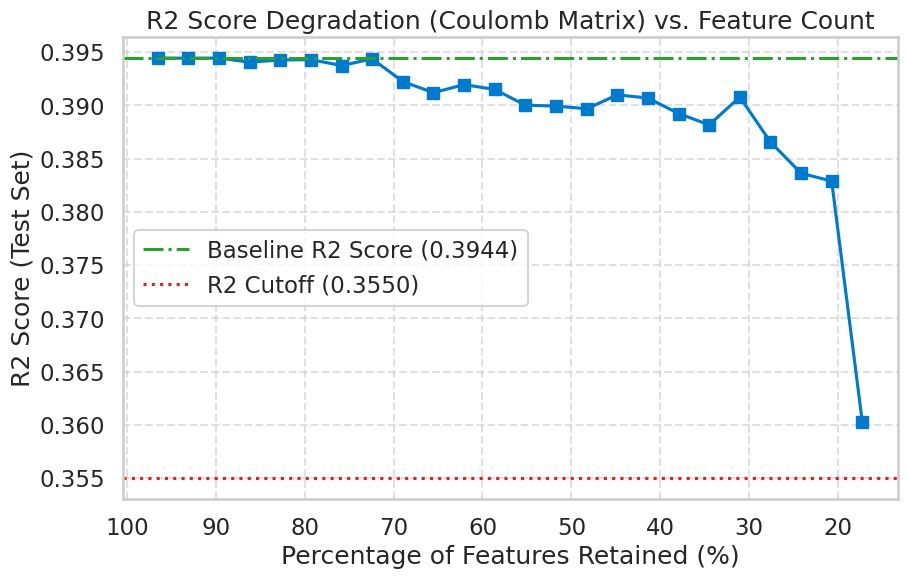

In [ ]:
# --- Plot RFE Degradation (CM) ---
print("\n4. Generating analysis plots for CM...")
plotar_degradacao_rfe(
    log_df_cm,
    r2_initial_test_cm,
    r2_initial_test_cm * LIMITE_RFE_R2_CM,
    len(all_feature_names_cm),
    "Coulomb Matrix"
)

# **Feature Space Visualization (PCA & t-SNE)**

Finally, we visualize the feature space to see if the descriptors cluster molecules by their bandgap. We use PCA (Principal Component Analysis) for a linear view and t-SNE for a non-linear view.


Generating PCA/t-SNE plots...
Calculating PCA (Full)...
Calculating PCA (Reduced)...
Calculating t-SNE (Full)... (this may take a while)
Calculating t-SNE (Reduced)...


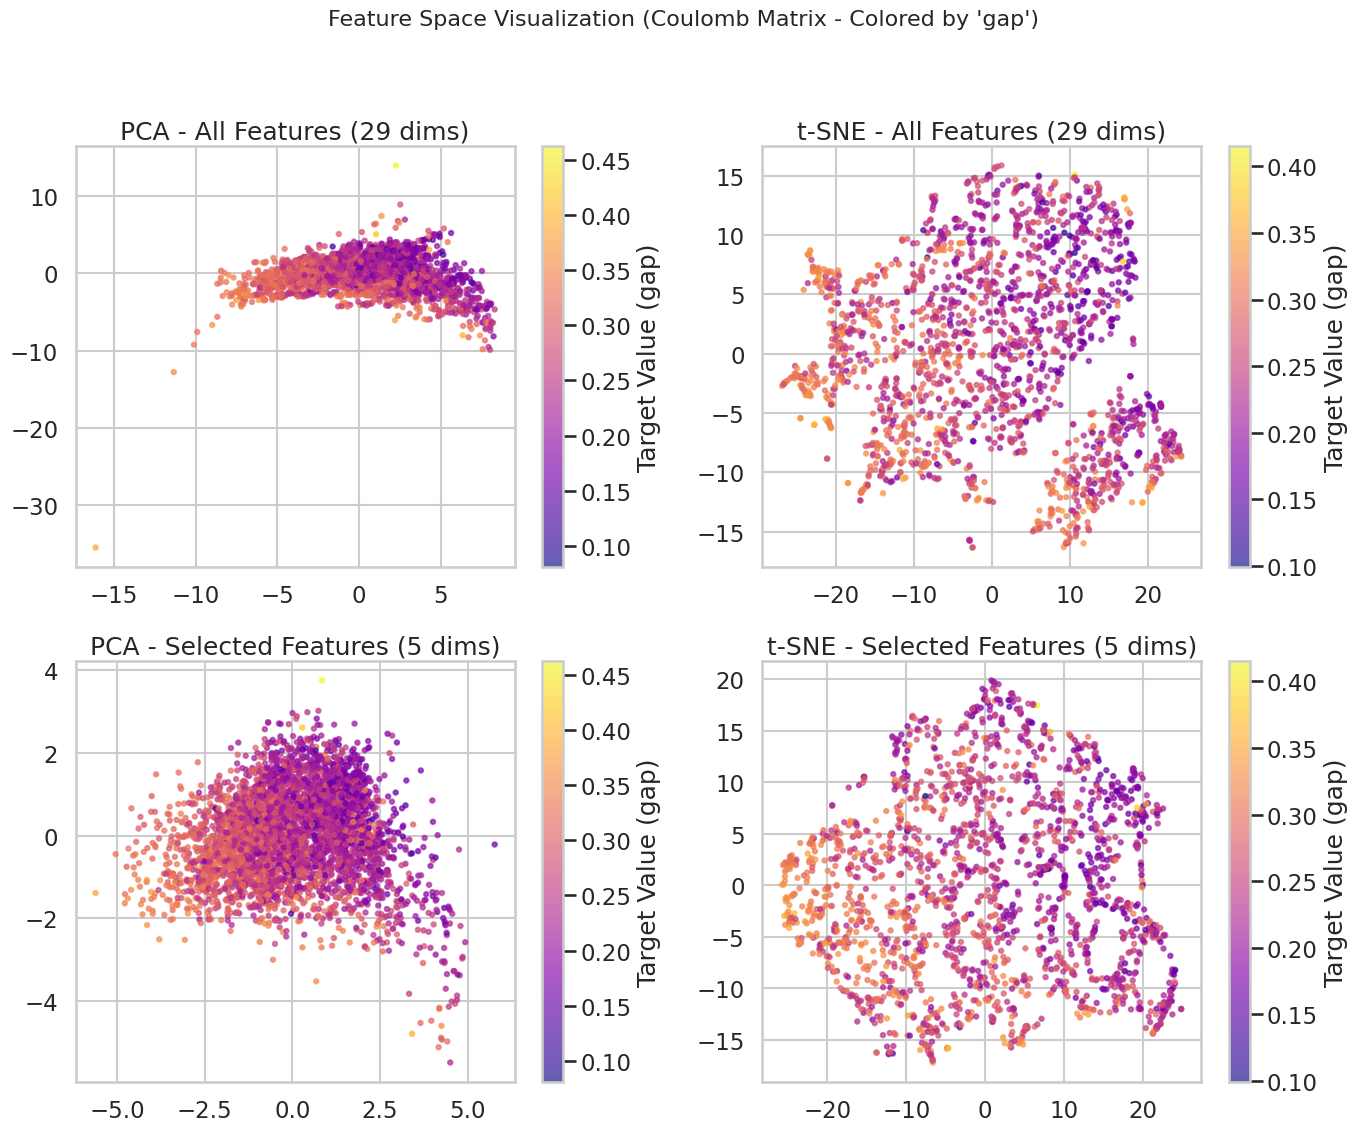


--- ANALYSIS COMPLETE FOR: Coulomb Matrix ---


In [ ]:
# --- Plot PCA/t-SNE (CM) ---
plotar_reducao_dim(
    X_train_scaled,
    y_train,
    final_names_cm,
    all_feature_names_cm,
    "Coulomb Matrix"
)
print(f"\n--- ANALYSIS COMPLETE FOR: Coulomb Matrix ---")

# **Many-Body Tensor Representation (MBTR)**

MBTR is a more complex, high-dimensional descriptor. We define terms for k=1 (atomic), k=2 (bonds/distance), and k=3 (angles).

In [ ]:
# --- Generate MBTR Descriptors ---
print("\n" + "="*80)
print(f"--- STARTING ANALYSIS: MBTR (k1, k2, k3) ---")
X_mbtr = gerar_descritores_mbtr(df['mol_ase'], n_jobs=-1)


--- STARTING ANALYSIS: MBTR (k1, k2, k3) ---
Generating MBTR descriptors (k1, k2, k3)...
MBTR descriptors generated. Shape: (5000, 4750)


In [ ]:
# --- Split and Scale (MBTR) ---
print("\n1. Splitting and scaling data (MBTR)...")
X_train, X_test, y_train, y_test = train_test_split(
    X_mbtr, y, test_size=0.2, random_state=SEED_GLOBAL
)

scaler_mbtr = StandardScaler()
X_train_scaled = scaler_mbtr.fit_transform(X_train)
X_test_scaled = scaler_mbtr.transform(X_test)
print("Data split and scaled.")


1. Splitting and scaling data (MBTR)...
Data split and scaled.


# **Evaluation Pipeline**

This function performs our evaluation and feature selection. It trains a LASSO CV model to find a baseline and rank features, then uses Ridge CV models to efficiently find the smallest feature subset that retains 95% accuracy (allowing a 5% MAE increase)

In [ ]:
# --- Train Initial Model (MBTR) ---
print("\n2. Training initial Lasso model (MBTR)...")
model_params = {'alpha': ALPHA_MBTR, 'max_iter': 2000}
lasso_mbtr = Lasso(**model_params)
lasso_mbtr.fit(X_train_scaled, y_train)

# Initial evaluation
y_train_pred = lasso_mbtr.predict(X_train_scaled)
y_test_pred = lasso_mbtr.predict(X_test_scaled)
mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_initial_train_mbtr = lasso_mbtr.score(X_train_scaled, y_train)
r2_initial_test_mbtr = lasso_mbtr.score(X_test_scaled, y_test)

print(f"  MAE Train: {mae_train:.4f}")
#print(f"  MAE Test:  {mae_test:.4f}")
print(f"  R2 Train:  {r2_initial_train_mbtr:.4f}")
#print(f"  R2 Test:   {r2_initial_test_mbtr:.4f} (Baseline for RFE)")
n_nao_nulos = len(lasso_mbtr.coef_.nonzero()[0])
total_features = X_mbtr.shape[1]
print(f"  Non-zero coefficients: {n_nao_nulos} / {total_features} ({n_nao_nulos/total_features*100:.2f}%)")


2. Training initial Lasso model (MBTR)...
  MAE Train: 0.0156
  R2 Train:  0.8303
  Non-zero coefficients: 118 / 4750 (2.48%)


In [ ]:
# --- Run Feature Selection (RFE - Batch) (MBTR) ---
#print("\n3. Running Feature Selection (RFE) for MBTR...")
all_feature_names_mbtr = [f'feature_{i}' for i in range(X_train_scaled.shape[1])]

final_names_mbtr, log_df_mbtr, rfe_time_mbtr = executar_rfe_batch(
    X_train_scaled, y_train, X_test_scaled, y_test,
    all_feature_names_mbtr, r2_initial_test_mbtr, LIMITE_RFE_R2_MBTR, ALPHA_MBTR,
    n_features_remover_inicial=N_FEATURES_REMOVER_BATCH
)

Initial R2 (on test set): 0.82630
R2 Threshold (target): 0.78499 (95.0%)
Initial removal batch size: 100


RFE (Batch):   0%|          | 0/4750 [00:00<?, ?it/s]


--- RFE (Batch) Loop Interrupted ---
Reason: R2 (0.78313) fell below threshold (0.78499)
Restoring last batch of 1 features.

Final number of features: 18
RFE execution time: 309.13 seconds


# **Accuracy Degradation vs. Feature Count**

This plot shows the trade-off between accuracy (MAE) and the number of features used.


4. Generating analysis plots for MBTR...


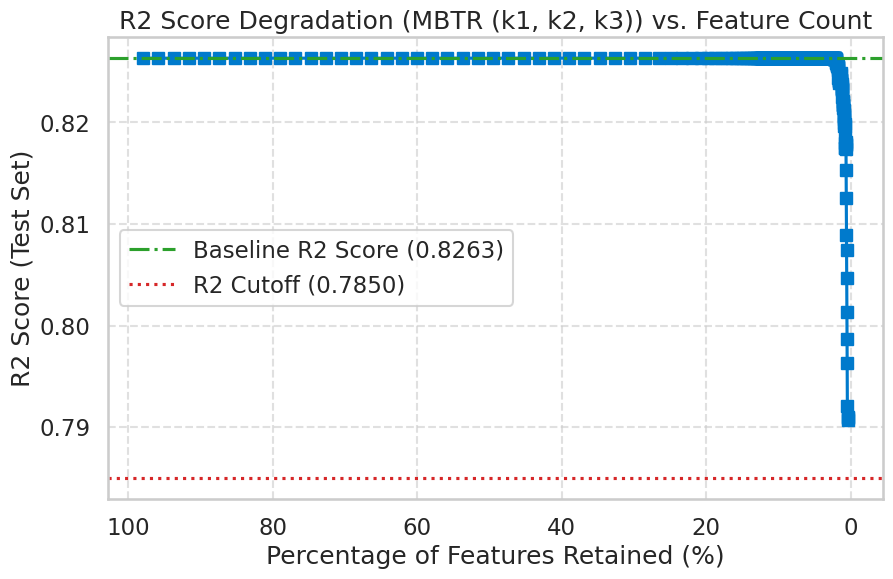

In [ ]:
# --- Plot RFE Degradation (MBTR) ---
print("\n4. Generating analysis plots for MBTR...")
plotar_degradacao_rfe(
    log_df_mbtr,
    r2_initial_test_mbtr,
    r2_initial_test_mbtr * LIMITE_RFE_R2_MBTR,
    len(all_feature_names_mbtr),
    "MBTR (k1, k2, k3)"
)

# **Feature Space Visualization (PCA & t-SNE)**

Finally, we visualize the feature space to see if the descriptors cluster molecules by their bandgap. We use PCA (Principal Component Analysis) for a linear view and t-SNE for a non-linear view.


Generating PCA/t-SNE plots...
Calculating PCA (Full)...
Calculating PCA (Reduced)...
Calculating t-SNE (Full)... (this may take a while)
Calculating t-SNE (Reduced)...


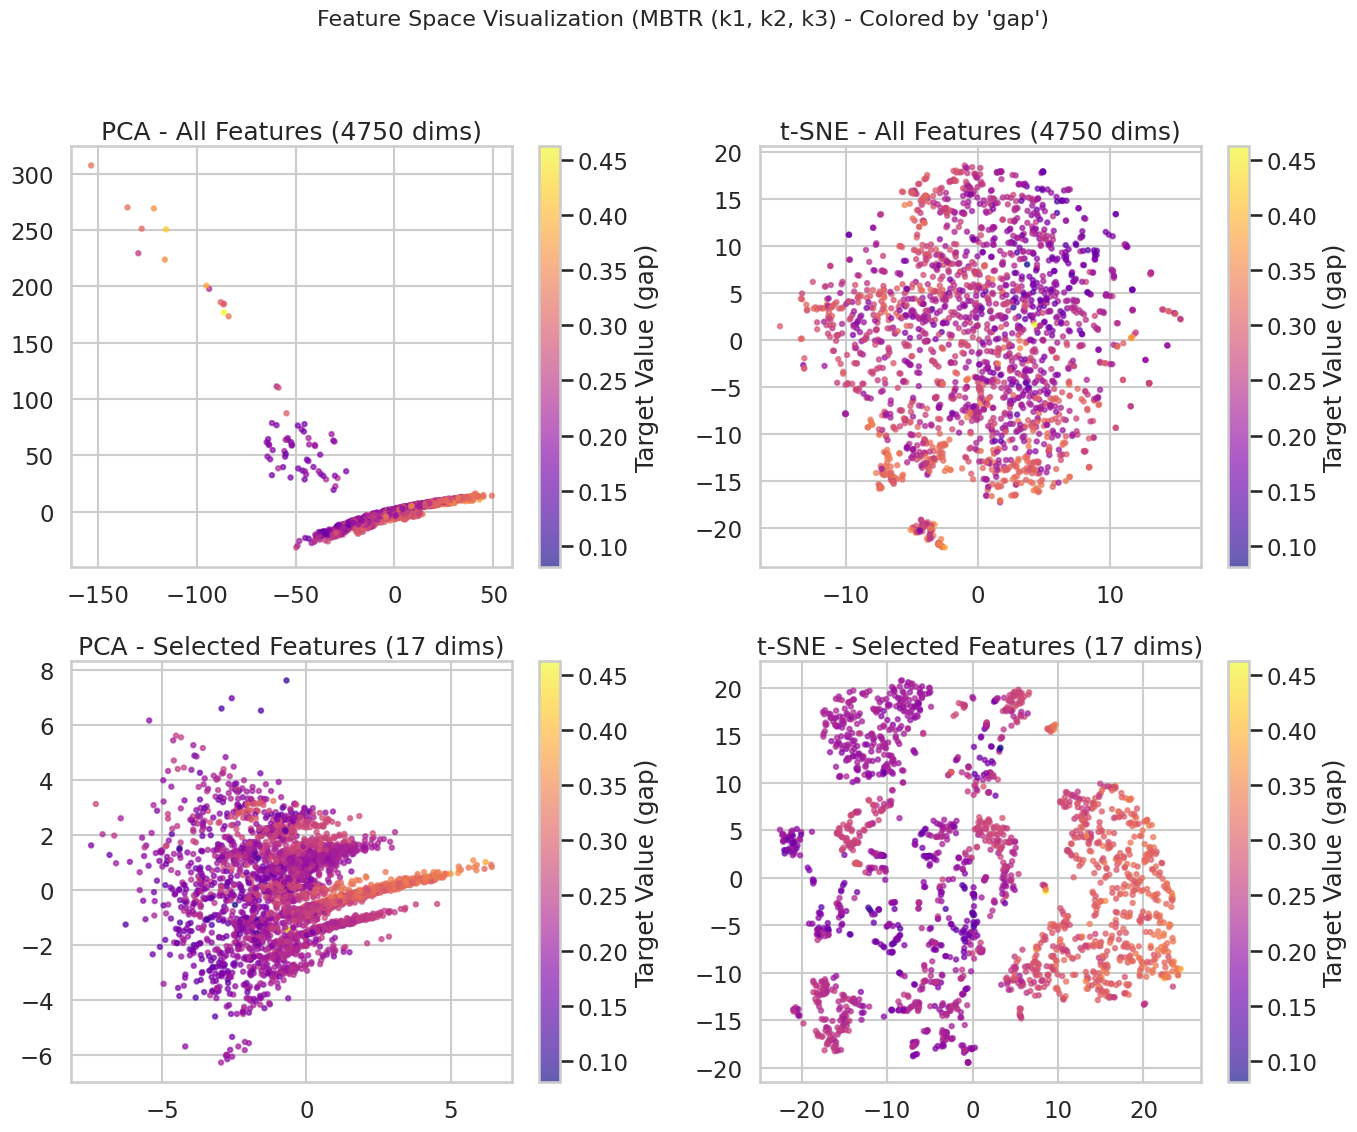


--- ANALYSIS COMPLETE FOR: MBTR ---


In [ ]:
# --- 6.5.2: Plot PCA/t-SNE (MBTR) ---
plotar_reducao_dim(
    X_train_scaled,
    y_train,
    final_names_mbtr,
    all_feature_names_mbtr,
    "MBTR (k1, k2, k3)"
)
print(f"\n--- ANALYSIS COMPLETE FOR: MBTR ---")